## Analysis

In this notebook, you will learn how to interpret the light curve of a start.

Requisites:
* a working Python 3.x environment, with **Astropy** (4.0), **Matplotlib** (3.1), **NumPy** (1.18), and **SciPy** (1.4) installed;
* a ```utils.py``` file with useful functions;
* a table with the magnitudes measured from a set of science frames (e.g. ```sci_2015/mags.fits```).

### Let's make the light curve

We can load up the magnitudes we have previously measured and format them as an Astropy table: 

In [2]:
from astropy.io import fits
from astropy.table import Table
mags = Table(fits.open('sci_2015/mags.fits')[1].data)
print(mags)

           file                   V                V_err        
------------------------- ----------------- --------------------
sci_2015/Reduced-001.fits  9.62112388244832 0.011462064286816733
sci_2015/Reduced-002.fits 9.624103594453558 0.011462064286816733
sci_2015/Reduced-003.fits 9.634745474104976 0.011462064286816733
sci_2015/Reduced-004.fits 9.641587396822633 0.011462064286816733
sci_2015/Reduced-005.fits 9.632890541512795 0.011462064286816733
sci_2015/Reduced-006.fits 9.645089344833352 0.011462064286816733
sci_2015/Reduced-007.fits  9.64470426369731 0.011462064286816733
sci_2015/Reduced-008.fits 9.651745325799773 0.011462064286816733
sci_2015/Reduced-009.fits  9.66310076573347 0.011462064286816733
sci_2015/Reduced-010.fits  9.65175444171449 0.011462064286816733
                      ...               ...                  ...
sci_2015/Reduced-200.fits 9.606819909333453 0.011462064286816733
sci_2015/Reduced-201.fits 9.586863156571056 0.011462064286816733
sci_2015/Reduced-202.fits

We need to relate each magnitude value with the time of observation, which is provided in Julian Day format in the frame headers:

In [6]:
import numpy as np

jd = np.array([fits.open(f)[0].header['JD-HELIO'] for f in mags['file']])

Now we can properly plot the light curve of the star:

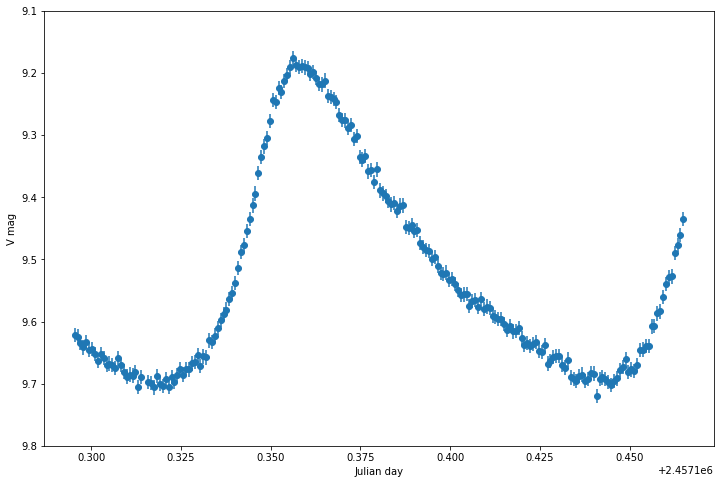

In [4]:
import matplotlib.pyplot as plt
from utils import plot_graph

mag, mag_err = np.array(mags['V'], dtype=float), np.array(mags['V_err'], dtype=float)
plot_graph(jd, mag, mode='errorbar', yerr=mag_err, fmt='o', xlabel='Julian day', ylabel='V mag')
plt.ylim(9.8, 9.1)
plt.show()

## Timing the fluctuations

A simple way to measure the period is to slide the light curve over itself along the time axis. We expect that the auto-correlation to be 1 at start (before sliding the curve) and to reach a maximum at some point, when the curve has been slid by exactly one period.

We use ```pearson``` from SciPy to compute the Pearson correlation coefficient. Of course, when the curve is slid, the region where it overlaps with the original curve shrinks down, increasing the error on the correlation coefficient.

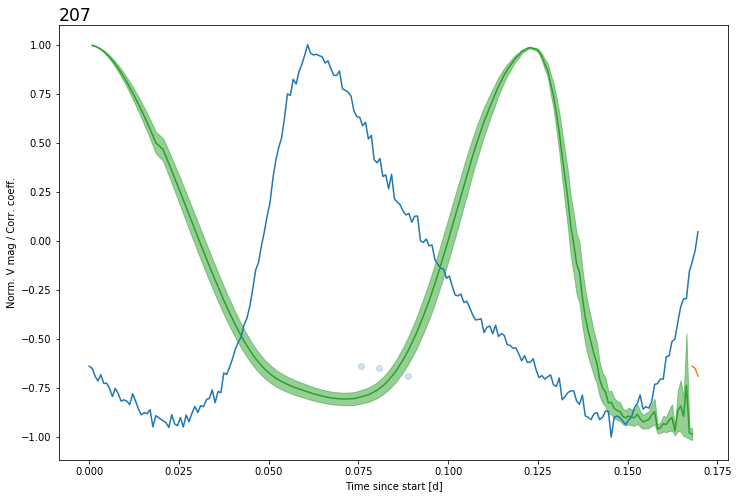

In [9]:
from scipy.stats import pearsonr
from utils import plot_graph, plot_refresh

r = np.array([])
dr = np.array([])

td = jd-jd[0]  # Time since start [d]
mag_norm = -2*(mag-0.5*(np.max(mag)+np.min(mag)))/(np.max(mag)-np.min(mag))  # Normalized V mag
mag_norm2 = 0.5*(mag_norm+1)*(np.max(td)-np.min(td))

for i in range(len(mag)):
#for i in range(20):

    if i>0 and len(mag[i:])>2:  # Cases accepted by pearsonr
        rp, _ = pearsonr(mag[i:],mag[:-i])
        r = np.append(r, rp)  # Pearson's correlation coefficient R
        dr = np.append(dr, (1-rp**2)/np.sqrt(len(mag[i:])-2))  # Uncertainty on R 
        plot_graph(td, mag_norm, xlabel='Time since start [d]', ylabel='Norm. V mag / Corr. coeff.')
        plot_graph(td[i:], mag_norm[:-i], new=False)
        plot_graph(td[:i+1], r, new=False, c='C2')
        plot_graph(mag_norm2[i:], mag_norm[:-i], mode='scatter', new=False, alpha=0.2)
        plt.fill_between(td[:i+1], r-dr, r+dr, color='C2', alpha=0.5)
        plot_refresh(i)
        plt.show()
    else:
        r = np.append(r, np.nan)
        dr = np.append(dr, np.nan)

The period is somewhere around 0.122 days. To better estimate it, let's zoom into that region of the plot:

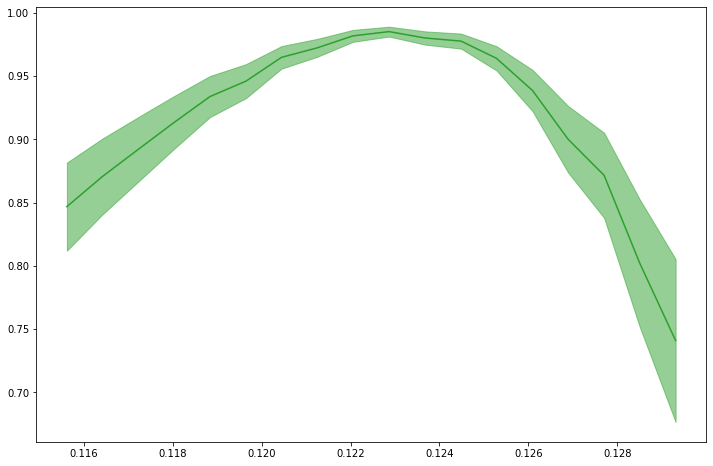

In [5]:
zoom = np.where(np.logical_and(td>0.115, td<0.13))

plot_graph(td[zoom], r[zoom], c='C2')
plt.fill_between(td[zoom], r[zoom]-dr[zoom], r[zoom]+dr[zoom], color='C2', alpha=0.5)
plt.show()

We can roughly take the maximum of ```r``` in this region as our estimate of the period, and the region where ```r+dr``` is greater than this value as the confidence interval for such estimate:

In [6]:
est = np.argmax(r[zoom])
ci = np.where(r[zoom]+dr[zoom]>r[zoom])

period = td[zoom][est]
period_lo = td[zoom][ci][0] - period
period_up = td[zoom][ci][-1] - period
print('Period: %3.3f (%3.3f +%3.3f) d' % (period, period_lo, period_up))

Period: 0.123 (-0.007 +0.006) d


This is very well agreement with the current best estimate of 0.12053492 d, albeit a lot less precise. We could have modeled the peak of the correlation coefficient in a more sophisticated way, but the better way to improve the estimation is to observe the star through several periods instead of one.

### Fast, Fourier, Transform!

Since the light curve is periodic, it makes sense to describe it in terms of frequencies, using the **Fourier transform**. This can be done with the Fast Fourier Transform (FFT) algorithm, included in SciPy. 

In our specific case, there are at least two caveats to be considered. Firstly, the FFT algorithm assumes that the time sampling is constant, which is only marginally true for our dataset: 

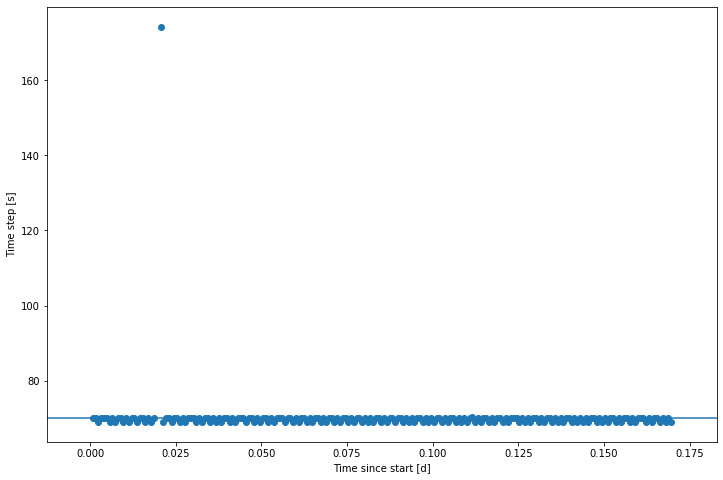

In [7]:
td_step = (td[1:]-td[:-1]) * 86400
td_med = np.median(td_step)

plot_graph(td[1:], td_step, mode='scatter', xlabel='Time since start [d]', ylabel='Time step [s]')
plt.axhline(td_med)
plt.show()

Secondly and most importantly, the time domain covered by our data is very limited. As a consequence, the frequency domain is severely undersampled, especially in the region where we expect to find the fundamental frequency of the oscillation, $f=1/p\simeq 8$d$^{-1}$ (shaded in the plot):

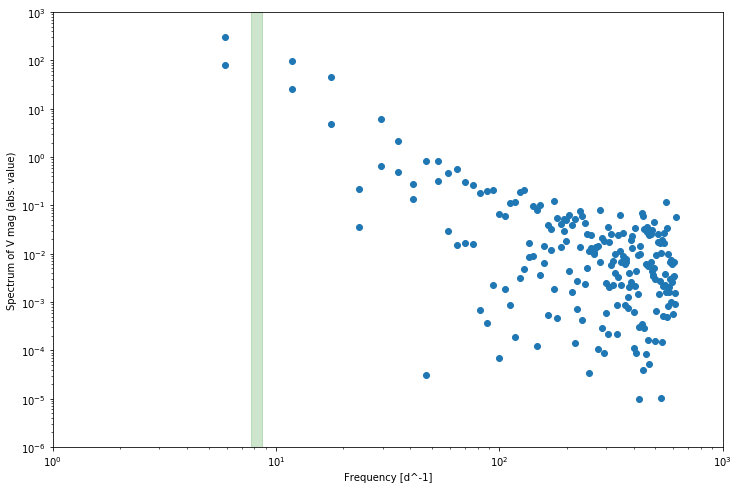

In [8]:
from scipy import fftpack as fft

n = len(mag)  # Length of light curve
f = fft.rfftfreq(n, td_med/86400)  # Frequency domain, in d^-1
mag_f = fft.rfft(mag)  # FFT of V mag
mag_s = mag_f**2  # Spectrum of V mag

plot_graph(f, mag_s, mode='scatter', xlabel='Frequency [d^-1]', ylabel='Spectrum of V mag (abs. value)')
plt.axvspan(1/0.116, 1/0.129, alpha=0.2, color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1,1e3)
plt.ylim(1e-6,1e3)
plt.show()